In [109]:
#!pip install plotly
#!pip install --upgrade nbformat
#!pip install nltk
#!pip install spacy # spaCy is an open-source software library for advanced natural language processing
#!pip install WordCloud
#!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hardikarora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
# load the data
df_val = pd.read_csv("FNID-dataset/dataset/fake news detection(FakeNewsNet)/fnn_dev.csv")
df_train = pd.read_csv("FNID-dataset/dataset/fake news detection(FakeNewsNet)/fnn_train.csv")
df_test = pd.read_csv("FNID-dataset/dataset/fake news detection(FakeNewsNet)/fnn_test.csv")

In [111]:
df_val

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake
...,...,...,...,...,...,...,...,...
1053,1819,2010-05-23T06:44:04-04:00,Bill White,"“In three days last week, (Gov. Rick) Perry f...",['http://alt.coxnewsweb.com/statesman/politifa...,"['In a Facebook post Wednesday, Democratic gu...","In a Facebook post Wednesday, Democratic gube...",fake
1054,15722,2018-08-14T10:00:00-04:00,Republican Governors Association,"Says Richard Cordray ""secretly collected hundr...",['https://www.youtube.com/watch?v=0pppWinN4D8'...,['A Republican group says that when Richard Co...,A Republican group says that when Richard Cord...,fake
1055,10562,2015-02-27T13:31:40-05:00,Jon Erpenbach,"""In general, it appears"" Wisconsin’s right to ...",['https://m.facebook.com/story.php?story_fbid=...,"['On Feb. 23, 2015, the night before a hearing...","On Feb. 23, 2015, the night before a hearing t...",real
1056,16526,2019-02-25T12:18:01-05:00,Donald Trump,"Says former Sen. Harry Reid ""got thrown out.""",['https://twitter.com/realDonaldTrump/status/1...,"['President Donald Trump famously said , ""When...","President Donald Trump famously said , ""When s...",fake


In [112]:
df_train

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,Says the Southwest Florida Water Management Di...,['http://www.tampabay.com/news/politics/gubern...,"[""Here's a new one: The Senate budget committe...",Here's a new one: The Senate budget committee ...,fake
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,"""The Congressional Budget Office has this econ...",['http://www.cnn.com/2011/POLITICS/03/17/gop.b...,"['Recently, House Budget chairman Paul Ryan, R...","Recently, House Budget chairman Paul Ryan, R-W...",real
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,"Says the Treasury Department ""says 41 percent ...",['http://frelinghuysen.house.gov/index.cfm?sec...,['The millionaires’ tax proposal made its late...,The millionaires’ tax proposal made its latest...,fake
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,Says veterans’ disability claims backlog doubl...,['https://twitter.com/johncornyn/status/270488...,"['In legislation filed this week , U.S. Sen. J...","In legislation filed this week , U.S. Sen. Joh...",real
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,"""In 2018, Biden lauded Paul Ryan for proposing...",['https://bernie.substack.com/p/bern-notice-be...,['Sen. Bernie Sanders argues that former Vice ...,Sen. Bernie Sanders argues that former Vice Pr...,fake
15209,16988,2019-06-18T12:06:24-04:00,Viral image,"Says Michael Bloomberg said, ""I have known Tru...",['https://www.facebook.com/liberalamerica.life...,"['Ready for some ""billionaire talk,"" as a rece...","Ready for some ""billionaire talk,"" as a recent...",fake
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,"In labor negotiations with city employees, Mil...",['http://www.wseu-24.org/issue_barrett_tom_201...,['We know why labor unions stand against Repub...,We know why labor unions stand against Republi...,fake


In [113]:
df_test

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,"""President Obama himself attempted to filibust...",['http://abcnews.go.com/ThisWeek/video/supreme...,['U.S. Supreme Court Justice John Paul Stevens...,U.S. Supreme Court Justice John Paul Stevens a...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,"In Hawaii, ""they don't have a history of throw...",['http://www.starbulletin.com/news/bulletin/94...,"[""On ABC's This Week, the chairmen of the Repu...","On ABC's This Week, the chairmen of the Republ...",real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,"""Our national debt ... is on track to exceed t...",['http://www.desmoinesregister.com/article/201...,['Ever since Barack Obama became president and...,Ever since Barack Obama became president and b...,real
3,1576,2010-03-12T11:45:14-05:00,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...","['http://www.youtube.com/watch?v=4O8CxZ1OD58',...","[""As the battle over health care reform approa...",As the battle over health care reform approach...,real
4,1770,2010-05-07T11:54:44-04:00,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",['http://www.huffingtonpost.com/michael-bloomb...,['In the wake of a foiled car bomb attempt in ...,In the wake of a foiled car bomb attempt in Ti...,real
...,...,...,...,...,...,...,...,...
1049,12070,2016-03-15T16:36:20-04:00,Hillary Clinton,"""Gun violence is by far the leading cause of d...",['https://medium.com/hillary-for-america/break...,"['In a speech posted on Medium , Democratic pr...","In a speech posted on Medium , Democratic pres...",real
1050,10423,2015-01-21T16:21:46-05:00,Barack Obama,"The economy is ""creating jobs at the fastest p...",['http://data.bls.gov/cgi-bin/surveymost?ln'],['President Barack Obama’s State of the Union ...,President Barack Obama’s State of the Union ad...,real
1051,12017,2016-03-08T12:51:40-05:00,Right to Rise,"Like Marco Rubio, Sen. Barack Obama had ""one o...","['https://youtu.be/uRqSUv_B7KI', 'https://www....",['A commercial by the super PAC Right to Rise ...,A commercial by the super PAC Right to Rise US...,real
1052,12120,2016-03-24T15:00:45-04:00,Bernie Sanders,"""Bernie Sanders passed more roll call amendmen...",['http://politicaladarchive.org/ad/PolAd_Berni...,"['Bernie Sanders is often criticized for "" pie...","Bernie Sanders is often criticized for "" pie -...",real


In [114]:
df_val.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [115]:
df_train.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [116]:
df_test.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [117]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1058 non-null   int64 
 1   date                     1058 non-null   object
 2   speaker                  1058 non-null   object
 3   statement                1058 non-null   object
 4   sources                  1058 non-null   object
 5   paragraph_based_content  1058 non-null   object
 6   fullText_based_content   1058 non-null   object
 7   label_fnn                1058 non-null   object
dtypes: int64(1), object(7)
memory usage: 66.2+ KB


In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15212 entries, 0 to 15211
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       15212 non-null  int64 
 1   date                     15212 non-null  object
 2   speaker                  15212 non-null  object
 3   statement                15212 non-null  object
 4   sources                  15212 non-null  object
 5   paragraph_based_content  15212 non-null  object
 6   fullText_based_content   15212 non-null  object
 7   label_fnn                15212 non-null  object
dtypes: int64(1), object(7)
memory usage: 950.9+ KB


In [119]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1054 non-null   int64 
 1   date                     1054 non-null   object
 2   speaker                  1054 non-null   object
 3   statement                1054 non-null   object
 4   sources                  1054 non-null   object
 5   paragraph_based_content  1054 non-null   object
 6   fullText_based_content   1054 non-null   object
 7   label_fnn                1054 non-null   object
dtypes: int64(1), object(7)
memory usage: 66.0+ KB


In [120]:
# add a target class column to indicate whether the news is real or fake
df_val.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake


In [121]:
df_train.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,Says the Southwest Florida Water Management Di...,['http://www.tampabay.com/news/politics/gubern...,"[""Here's a new one: The Senate budget committe...",Here's a new one: The Senate budget committee ...,fake
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,"""The Congressional Budget Office has this econ...",['http://www.cnn.com/2011/POLITICS/03/17/gop.b...,"['Recently, House Budget chairman Paul Ryan, R...","Recently, House Budget chairman Paul Ryan, R-W...",real
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,"Says the Treasury Department ""says 41 percent ...",['http://frelinghuysen.house.gov/index.cfm?sec...,['The millionaires’ tax proposal made its late...,The millionaires’ tax proposal made its latest...,fake


In [122]:
df_test.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,"""President Obama himself attempted to filibust...",['http://abcnews.go.com/ThisWeek/video/supreme...,['U.S. Supreme Court Justice John Paul Stevens...,U.S. Supreme Court Justice John Paul Stevens a...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,"In Hawaii, ""they don't have a history of throw...",['http://www.starbulletin.com/news/bulletin/94...,"[""On ABC's This Week, the chairmen of the Repu...","On ABC's This Week, the chairmen of the Republ...",real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,"""Our national debt ... is on track to exceed t...",['http://www.desmoinesregister.com/article/201...,['Ever since Barack Obama became president and...,Ever since Barack Obama became president and b...,real
3,1576,2010-03-12T11:45:14-05:00,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...","['http://www.youtube.com/watch?v=4O8CxZ1OD58',...","[""As the battle over health care reform approa...",As the battle over health care reform approach...,real
4,1770,2010-05-07T11:54:44-04:00,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",['http://www.huffingtonpost.com/michael-bloomb...,['In the wake of a foiled car bomb attempt in ...,In the wake of a foiled car bomb attempt in Ti...,real


In [123]:
df = pd.concat([df_val, df_train]).reset_index(drop = True)
df

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake
...,...,...,...,...,...,...,...,...
16265,7125,2012-11-28T16:57:04-05:00,John Cornyn,Says veterans’ disability claims backlog doubl...,['https://twitter.com/johncornyn/status/270488...,"['In legislation filed this week , U.S. Sen. J...","In legislation filed this week , U.S. Sen. Joh...",real
16266,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,"""In 2018, Biden lauded Paul Ryan for proposing...",['https://bernie.substack.com/p/bern-notice-be...,['Sen. Bernie Sanders argues that former Vice ...,Sen. Bernie Sanders argues that former Vice Pr...,fake
16267,16988,2019-06-18T12:06:24-04:00,Viral image,"Says Michael Bloomberg said, ""I have known Tru...",['https://www.facebook.com/liberalamerica.life...,"['Ready for some ""billionaire talk,"" as a rece...","Ready for some ""billionaire talk,"" as a recent...",fake
16268,5758,2012-04-18T09:00:00-04:00,AFSCME,"In labor negotiations with city employees, Mil...",['http://www.wseu-24.org/issue_barrett_tom_201...,['We know why labor unions stand against Repub...,We know why labor unions stand against Republi...,fake


In [124]:
df1 = df_test.reset_index(drop = True)
df1

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,"""President Obama himself attempted to filibust...",['http://abcnews.go.com/ThisWeek/video/supreme...,['U.S. Supreme Court Justice John Paul Stevens...,U.S. Supreme Court Justice John Paul Stevens a...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,"In Hawaii, ""they don't have a history of throw...",['http://www.starbulletin.com/news/bulletin/94...,"[""On ABC's This Week, the chairmen of the Repu...","On ABC's This Week, the chairmen of the Republ...",real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,"""Our national debt ... is on track to exceed t...",['http://www.desmoinesregister.com/article/201...,['Ever since Barack Obama became president and...,Ever since Barack Obama became president and b...,real
3,1576,2010-03-12T11:45:14-05:00,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...","['http://www.youtube.com/watch?v=4O8CxZ1OD58',...","[""As the battle over health care reform approa...",As the battle over health care reform approach...,real
4,1770,2010-05-07T11:54:44-04:00,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",['http://www.huffingtonpost.com/michael-bloomb...,['In the wake of a foiled car bomb attempt in ...,In the wake of a foiled car bomb attempt in Ti...,real
...,...,...,...,...,...,...,...,...
1049,12070,2016-03-15T16:36:20-04:00,Hillary Clinton,"""Gun violence is by far the leading cause of d...",['https://medium.com/hillary-for-america/break...,"['In a speech posted on Medium , Democratic pr...","In a speech posted on Medium , Democratic pres...",real
1050,10423,2015-01-21T16:21:46-05:00,Barack Obama,"The economy is ""creating jobs at the fastest p...",['http://data.bls.gov/cgi-bin/surveymost?ln'],['President Barack Obama’s State of the Union ...,President Barack Obama’s State of the Union ad...,real
1051,12017,2016-03-08T12:51:40-05:00,Right to Rise,"Like Marco Rubio, Sen. Barack Obama had ""one o...","['https://youtu.be/uRqSUv_B7KI', 'https://www....",['A commercial by the super PAC Right to Rise ...,A commercial by the super PAC Right to Rise US...,real
1052,12120,2016-03-24T15:00:45-04:00,Bernie Sanders,"""Bernie Sanders passed more roll call amendmen...",['http://politicaladarchive.org/ad/PolAd_Berni...,"['Bernie Sanders is often criticized for "" pie...","Bernie Sanders is often criticized for "" pie -...",real


In [125]:
df.drop(columns = ['date'], inplace = True)
df.drop(columns = ['paragraph_based_content'], inplace = True)
df.drop(columns = ['sources'], inplace = True)

In [126]:
df1.drop(columns = ['date'], inplace = True)
df1.drop(columns = ['paragraph_based_content'], inplace = True)
df1.drop(columns = ['sources'], inplace = True)

In [127]:
# combine title and text together
df['original'] = df['statement'] + ' ' + df['fullText_based_content']
df.head()

,id,speaker,statement,fullText_based_content,label_fnn,original
0,1636,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",Gov. Charlie Crist launched what amounts to a ...,fake,"Rubio's tax swap proposal ""would have been a m..."
1,4352,Bobby Scott,"""The estimated savings of this (debt ceiling) ...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,"""The estimated savings of this (debt ceiling) ..."
2,16471,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",Amid reports questioning Foxconn Technology Gr...,fake,"Foxconn has already ""made a positive impact ac..."
3,1557,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","State Sen. Dave Aronberg, a Democratic candida...",real,"Says Gov. Charlie Crist has called him ""a rock..."
4,12826,Jeannette Vaught,"""Only five Texas counties account for almost 9...",From the citrus of the Rio Grande Valley to th...,fake,"""Only five Texas counties account for almost 9..."


In [128]:
# combine title and text together
df1['original'] = df1['statement'] + ' ' + df1['fullText_based_content']
df1.head()

,id,speaker,statement,fullText_based_content,label_fnn,original
0,1678,Jon Kyl,"""President Obama himself attempted to filibust...",U.S. Supreme Court Justice John Paul Stevens a...,real,"""President Obama himself attempted to filibust..."
1,1820,Michael Steele,"In Hawaii, ""they don't have a history of throw...","On ABC's This Week, the chairmen of the Republ...",real,"In Hawaii, ""they don't have a history of throw..."
2,1624,John Boehner,"""Our national debt ... is on track to exceed t...",Ever since Barack Obama became president and b...,real,"""Our national debt ... is on track to exceed t..."
3,1576,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...",As the battle over health care reform approach...,real,"""Health insurance companies' costs are only 4 ..."
4,1770,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",In the wake of a foiled car bomb attempt in Ti...,real,"""We can prevent terror suspects from boarding ..."


In [129]:
df['original'][0]

'Rubio\'s tax swap proposal "would have been a massive tax increase." Gov. Charlie Crist launched what amounts to a nuclear attack in Republican politics during his FOX News Sunday showdown with Marco Rubio.\nCrist labeled Rubio, the former House speaker, a tax raiser.\nIn a back and forth about each other\'s record on tax issues, Crist singled out Rubio\'s failed 2007 plan that would have eliminated property taxes for many Floridians in exchange for an increase to the state sales tax.\nThe tax swap "would have been a massive tax increase," Crist said during the March 28, 2010, U.S. Senate debate. "In all due respect to the speaker, you\'ve just got to tell the truth to people. And that\'s really what this is all about."\nRubio contends that the tax swap would have been a huge, net tax cut. And that the plan was supported by former Gov. Jeb Bush.\nWould it have been a tax cut? Or a tax hike?\nLet\'s take a look.\nIn his first months as speaker in early 2007, Rubio proposed a fundamenta

In [130]:
df1['original'][0]

'"President Obama himself attempted to filibuster Justice Alito, who  now sits on the Supreme Court." U.S. Supreme Court Justice John Paul Stevens announced his retirement  last week, and while President Obama has not yet announced his nominee,  U.S. senators are already discussing prospects of a filibuster.\nDemocrats  in the Senate hold 59 votes, one short of the 60 needed to bring  nominees or legislation to an up or down vote.\nRepublican Sen.  Jon Kyl of Arizona, who sits on the Judiciary Committee, said he thought  a filibuster was unlikely, but he wasn\'t taking it entirely off the  table as an option. Kyl appeared on ABC News\' This Week, alongside  Democratic Sen. Charles Schumer of New York.\n"President Obama  himself attempted to filibuster Justice Alito, who now sits on the  Supreme Court," Kyl said. "So if the president isn\'t going to take it  off the table, I\'m not going to take it off the table. But I think it  can easily be avoided by appointing, frankly, the kind of 

In [131]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hardikarora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [133]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [134]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [135]:
# Apply the function to the dataframe
df1['clean'] = df1['original'].apply(preprocess)

In [136]:
# Show original news
df['original'][0]

'Rubio\'s tax swap proposal "would have been a massive tax increase." Gov. Charlie Crist launched what amounts to a nuclear attack in Republican politics during his FOX News Sunday showdown with Marco Rubio.\nCrist labeled Rubio, the former House speaker, a tax raiser.\nIn a back and forth about each other\'s record on tax issues, Crist singled out Rubio\'s failed 2007 plan that would have eliminated property taxes for many Floridians in exchange for an increase to the state sales tax.\nThe tax swap "would have been a massive tax increase," Crist said during the March 28, 2010, U.S. Senate debate. "In all due respect to the speaker, you\'ve just got to tell the truth to people. And that\'s really what this is all about."\nRubio contends that the tax swap would have been a huge, net tax cut. And that the plan was supported by former Gov. Jeb Bush.\nWould it have been a tax cut? Or a tax hike?\nLet\'s take a look.\nIn his first months as speaker in early 2007, Rubio proposed a fundamenta

In [137]:
# Show original news
df1['original'][0]

'"President Obama himself attempted to filibuster Justice Alito, who  now sits on the Supreme Court." U.S. Supreme Court Justice John Paul Stevens announced his retirement  last week, and while President Obama has not yet announced his nominee,  U.S. senators are already discussing prospects of a filibuster.\nDemocrats  in the Senate hold 59 votes, one short of the 60 needed to bring  nominees or legislation to an up or down vote.\nRepublican Sen.  Jon Kyl of Arizona, who sits on the Judiciary Committee, said he thought  a filibuster was unlikely, but he wasn\'t taking it entirely off the  table as an option. Kyl appeared on ABC News\' This Week, alongside  Democratic Sen. Charles Schumer of New York.\n"President Obama  himself attempted to filibuster Justice Alito, who now sits on the  Supreme Court," Kyl said. "So if the president isn\'t going to take it  off the table, I\'m not going to take it off the table. But I think it  can easily be avoided by appointing, frankly, the kind of 

In [138]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['rubio', 'swap', 'proposal', 'massive', 'increase', 'charlie', 'crist', 'launched', 'amounts', 'nuclear', 'attack', 'republican', 'politics', 'news', 'sunday', 'showdown', 'marco', 'rubio', 'crist', 'labeled', 'rubio', 'house', 'speaker', 'raiser', 'forth', 'record', 'issues', 'crist', 'singled', 'rubio', 'failed', 'plan', 'eliminated', 'property', 'taxes', 'floridians', 'exchange', 'increase', 'state', 'sales', 'swap', 'massive', 'increase', 'crist', 'said', 'march', 'senate', 'debate', 'respect', 'speaker', 'tell', 'truth', 'people', 'rubio', 'contends', 'swap', 'huge', 'plan', 'supported', 'bush', 'hike', 'look', 'months', 'speaker', 'early', 'rubio', 'proposed', 'fundamental', 'change', 'florida', 'structure', 'proposal', 'scratch', 'property', 'taxes', 'primary', 'residences', 'place', 'state', 'sales', 'increased', 'cents', 'dollar', 'voter', 'approval', 'house', 'analysis', 'originally', 'said', 'swap', 'save', 'taxpayers', 'total', 'billion', 'year', 'certainly', 'contrary', '

In [139]:
# Show cleaned up news after removing stopwords
print(df1['clean'][0])

['president', 'obama', 'attempted', 'filibuster', 'justice', 'alito', 'sits', 'supreme', 'court', 'supreme', 'court', 'justice', 'john', 'paul', 'stevens', 'announced', 'retirement', 'week', 'president', 'obama', 'announced', 'nominee', 'senators', 'discussing', 'prospects', 'filibuster', 'democrats', 'senate', 'hold', 'votes', 'short', 'needed', 'bring', 'nominees', 'legislation', 'vote', 'republican', 'arizona', 'sits', 'judiciary', 'committee', 'said', 'thought', 'filibuster', 'unlikely', 'taking', 'entirely', 'table', 'option', 'appeared', 'news', 'week', 'alongside', 'democratic', 'charles', 'schumer', 'york', 'president', 'obama', 'attempted', 'filibuster', 'justice', 'alito', 'sits', 'supreme', 'court', 'said', 'president', 'going', 'table', 'going', 'table', 'think', 'easily', 'avoided', 'appointing', 'frankly', 'kind', 'person', 'senator', 'schumer', 'mentioned', 'mainstream', 'intellect', 'application', 'good', 'persuade', 'colleagues', 'support', 'position', 'position', 'wan

In [140]:
df

,id,speaker,statement,fullText_based_content,label_fnn,original,clean
0,1636,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",Gov. Charlie Crist launched what amounts to a ...,fake,"Rubio's tax swap proposal ""would have been a m...","[rubio, swap, proposal, massive, increase, cha..."
1,4352,Bobby Scott,"""The estimated savings of this (debt ceiling) ...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,"""The estimated savings of this (debt ceiling) ...","[estimated, savings, debt, ceiling, deal, half..."
2,16471,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",Amid reports questioning Foxconn Technology Gr...,fake,"Foxconn has already ""made a positive impact ac...","[foxconn, positive, impact, wisconsin, jobs, a..."
3,1557,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","State Sen. Dave Aronberg, a Democratic candida...",real,"Says Gov. Charlie Crist has called him ""a rock...","[says, charlie, crist, called, rock, star, sta..."
4,12826,Jeannette Vaught,"""Only five Texas counties account for almost 9...",From the citrus of the Rio Grande Valley to th...,fake,"""Only five Texas counties account for almost 9...","[texas, counties, account, percent, state, cat..."
...,...,...,...,...,...,...,...
16265,7125,John Cornyn,Says veterans’ disability claims backlog doubl...,"In legislation filed this week , U.S. Sen. Joh...",real,Says veterans’ disability claims backlog doubl...,"[says, veterans, disability, claims, backlog, ..."
16266,17742,Bernie Sanders,"""In 2018, Biden lauded Paul Ryan for proposing...",Sen. Bernie Sanders argues that former Vice Pr...,fake,"""In 2018, Biden lauded Paul Ryan for proposing...","[biden, lauded, paul, ryan, proposing, cuts, s..."
16267,16988,Viral image,"Says Michael Bloomberg said, ""I have known Tru...","Ready for some ""billionaire talk,"" as a recent...",fake,"Says Michael Bloomberg said, ""I have known Tru...","[says, michael, bloomberg, said, known, trump,..."
16268,5758,AFSCME,"In labor negotiations with city employees, Mil...",We know why labor unions stand against Republi...,fake,"In labor negotiations with city employees, Mil...","[labor, negotiations, city, employees, milwauk..."


In [141]:
df1

,id,speaker,statement,fullText_based_content,label_fnn,original,clean
0,1678,Jon Kyl,"""President Obama himself attempted to filibust...",U.S. Supreme Court Justice John Paul Stevens a...,real,"""President Obama himself attempted to filibust...","[president, obama, attempted, filibuster, just..."
1,1820,Michael Steele,"In Hawaii, ""they don't have a history of throw...","On ABC's This Week, the chairmen of the Republ...",real,"In Hawaii, ""they don't have a history of throw...","[hawaii, history, throwing, incumbents, office..."
2,1624,John Boehner,"""Our national debt ... is on track to exceed t...",Ever since Barack Obama became president and b...,real,"""Our national debt ... is on track to exceed t...","[national, debt, track, exceed, size, entire, ..."
3,1576,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...",As the battle over health care reform approach...,real,"""Health insurance companies' costs are only 4 ...","[health, insurance, companies, costs, percent,..."
4,1770,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",In the wake of a foiled car bomb attempt in Ti...,real,"""We can prevent terror suspects from boarding ...","[prevent, terror, suspects, boarding, airplane..."
...,...,...,...,...,...,...,...
1049,12070,Hillary Clinton,"""Gun violence is by far the leading cause of d...","In a speech posted on Medium , Democratic pres...",real,"""Gun violence is by far the leading cause of d...","[violence, leading, cause, death, young, afric..."
1050,10423,Barack Obama,"The economy is ""creating jobs at the fastest p...",President Barack Obama’s State of the Union ad...,real,"The economy is ""creating jobs at the fastest p...","[economy, creating, jobs, fastest, pace, presi..."
1051,12017,Right to Rise,"Like Marco Rubio, Sen. Barack Obama had ""one o...",A commercial by the super PAC Right to Rise US...,real,"Like Marco Rubio, Sen. Barack Obama had ""one o...","[like, marco, rubio, barack, obama, worst, att..."
1052,12120,Bernie Sanders,"""Bernie Sanders passed more roll call amendmen...","Bernie Sanders is often criticized for "" pie -...",real,"""Bernie Sanders passed more roll call amendmen...","[bernie, sanders, passed, roll, amendments, re..."


In [142]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [143]:
# Obtain the total words present in the dataset
list_of_words1 = []
for i in df1.clean:
    for j in i:
        list_of_words1.append(j)


In [144]:
list_of_words

['rubio',
 'swap',
 'proposal',
 'massive',
 'increase',
 'charlie',
 'crist',
 'launched',
 'amounts',
 'nuclear',
 'attack',
 'republican',
 'politics',
 'news',
 'sunday',
 'showdown',
 'marco',
 'rubio',
 'crist',
 'labeled',
 'rubio',
 'house',
 'speaker',
 'raiser',
 'forth',
 'record',
 'issues',
 'crist',
 'singled',
 'rubio',
 'failed',
 'plan',
 'eliminated',
 'property',
 'taxes',
 'floridians',
 'exchange',
 'increase',
 'state',
 'sales',
 'swap',
 'massive',
 'increase',
 'crist',
 'said',
 'march',
 'senate',
 'debate',
 'respect',
 'speaker',
 'tell',
 'truth',
 'people',
 'rubio',
 'contends',
 'swap',
 'huge',
 'plan',
 'supported',
 'bush',
 'hike',
 'look',
 'months',
 'speaker',
 'early',
 'rubio',
 'proposed',
 'fundamental',
 'change',
 'florida',
 'structure',
 'proposal',
 'scratch',
 'property',
 'taxes',
 'primary',
 'residences',
 'place',
 'state',
 'sales',
 'increased',
 'cents',
 'dollar',
 'voter',
 'approval',
 'house',
 'analysis',
 'originally',
 'sa

In [145]:
list_of_words1

['president',
 'obama',
 'attempted',
 'filibuster',
 'justice',
 'alito',
 'sits',
 'supreme',
 'court',
 'supreme',
 'court',
 'justice',
 'john',
 'paul',
 'stevens',
 'announced',
 'retirement',
 'week',
 'president',
 'obama',
 'announced',
 'nominee',
 'senators',
 'discussing',
 'prospects',
 'filibuster',
 'democrats',
 'senate',
 'hold',
 'votes',
 'short',
 'needed',
 'bring',
 'nominees',
 'legislation',
 'vote',
 'republican',
 'arizona',
 'sits',
 'judiciary',
 'committee',
 'said',
 'thought',
 'filibuster',
 'unlikely',
 'taking',
 'entirely',
 'table',
 'option',
 'appeared',
 'news',
 'week',
 'alongside',
 'democratic',
 'charles',
 'schumer',
 'york',
 'president',
 'obama',
 'attempted',
 'filibuster',
 'justice',
 'alito',
 'sits',
 'supreme',
 'court',
 'said',
 'president',
 'going',
 'table',
 'going',
 'table',
 'think',
 'easily',
 'avoided',
 'appointing',
 'frankly',
 'kind',
 'person',
 'senator',
 'schumer',
 'mentioned',
 'mainstream',
 'intellect',
 'app

In [146]:
len(list_of_words)

6198763

In [147]:
len(list_of_words1)

278725

In [148]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

66249

In [149]:
# Obtain the total number of unique words
total_words1 = len(list(set(list_of_words1)))
total_words1

19449

In [150]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [151]:
# join the words into a string
df1['clean_joined'] = df1['clean'].apply(lambda x: " ".join(x))

In [152]:
df

,id,speaker,statement,fullText_based_content,label_fnn,original,clean,clean_joined
0,1636,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",Gov. Charlie Crist launched what amounts to a ...,fake,"Rubio's tax swap proposal ""would have been a m...","[rubio, swap, proposal, massive, increase, cha...",rubio swap proposal massive increase charlie c...
1,4352,Bobby Scott,"""The estimated savings of this (debt ceiling) ...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,"""The estimated savings of this (debt ceiling) ...","[estimated, savings, debt, ceiling, deal, half...",estimated savings debt ceiling deal half cost ...
2,16471,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",Amid reports questioning Foxconn Technology Gr...,fake,"Foxconn has already ""made a positive impact ac...","[foxconn, positive, impact, wisconsin, jobs, a...",foxconn positive impact wisconsin jobs amid re...
3,1557,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","State Sen. Dave Aronberg, a Democratic candida...",real,"Says Gov. Charlie Crist has called him ""a rock...","[says, charlie, crist, called, rock, star, sta...",says charlie crist called rock star state dave...
4,12826,Jeannette Vaught,"""Only five Texas counties account for almost 9...",From the citrus of the Rio Grande Valley to th...,fake,"""Only five Texas counties account for almost 9...","[texas, counties, account, percent, state, cat...",texas counties account percent state cattle in...
...,...,...,...,...,...,...,...,...
16265,7125,John Cornyn,Says veterans’ disability claims backlog doubl...,"In legislation filed this week , U.S. Sen. Joh...",real,Says veterans’ disability claims backlog doubl...,"[says, veterans, disability, claims, backlog, ...",says veterans disability claims backlog double...
16266,17742,Bernie Sanders,"""In 2018, Biden lauded Paul Ryan for proposing...",Sen. Bernie Sanders argues that former Vice Pr...,fake,"""In 2018, Biden lauded Paul Ryan for proposing...","[biden, lauded, paul, ryan, proposing, cuts, s...",biden lauded paul ryan proposing cuts social s...
16267,16988,Viral image,"Says Michael Bloomberg said, ""I have known Tru...","Ready for some ""billionaire talk,"" as a recent...",fake,"Says Michael Bloomberg said, ""I have known Tru...","[says, michael, bloomberg, said, known, trump,...",says michael bloomberg said known trump decade...
16268,5758,AFSCME,"In labor negotiations with city employees, Mil...",We know why labor unions stand against Republi...,fake,"In labor negotiations with city employees, Mil...","[labor, negotiations, city, employees, milwauk...",labor negotiations city employees milwaukee ma...


In [153]:
df1

,id,speaker,statement,fullText_based_content,label_fnn,original,clean,clean_joined
0,1678,Jon Kyl,"""President Obama himself attempted to filibust...",U.S. Supreme Court Justice John Paul Stevens a...,real,"""President Obama himself attempted to filibust...","[president, obama, attempted, filibuster, just...",president obama attempted filibuster justice a...
1,1820,Michael Steele,"In Hawaii, ""they don't have a history of throw...","On ABC's This Week, the chairmen of the Republ...",real,"In Hawaii, ""they don't have a history of throw...","[hawaii, history, throwing, incumbents, office...",hawaii history throwing incumbents office week...
2,1624,John Boehner,"""Our national debt ... is on track to exceed t...",Ever since Barack Obama became president and b...,real,"""Our national debt ... is on track to exceed t...","[national, debt, track, exceed, size, entire, ...",national debt track exceed size entire economy...
3,1576,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...",As the battle over health care reform approach...,real,"""Health insurance companies' costs are only 4 ...","[health, insurance, companies, costs, percent,...",health insurance companies costs percent healt...
4,1770,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",In the wake of a foiled car bomb attempt in Ti...,real,"""We can prevent terror suspects from boarding ...","[prevent, terror, suspects, boarding, airplane...",prevent terror suspects boarding airplane powe...
...,...,...,...,...,...,...,...,...
1049,12070,Hillary Clinton,"""Gun violence is by far the leading cause of d...","In a speech posted on Medium , Democratic pres...",real,"""Gun violence is by far the leading cause of d...","[violence, leading, cause, death, young, afric...",violence leading cause death young african ame...
1050,10423,Barack Obama,"The economy is ""creating jobs at the fastest p...",President Barack Obama’s State of the Union ad...,real,"The economy is ""creating jobs at the fastest p...","[economy, creating, jobs, fastest, pace, presi...",economy creating jobs fastest pace president b...
1051,12017,Right to Rise,"Like Marco Rubio, Sen. Barack Obama had ""one o...",A commercial by the super PAC Right to Rise US...,real,"Like Marco Rubio, Sen. Barack Obama had ""one o...","[like, marco, rubio, barack, obama, worst, att...",like marco rubio barack obama worst attendance...
1052,12120,Bernie Sanders,"""Bernie Sanders passed more roll call amendmen...","Bernie Sanders is often criticized for "" pie -...",real,"""Bernie Sanders passed more roll call amendmen...","[bernie, sanders, passed, roll, amendments, re...",bernie sanders passed roll amendments republic...


In [154]:
df['clean_joined'][0]

'rubio swap proposal massive increase charlie crist launched amounts nuclear attack republican politics news sunday showdown marco rubio crist labeled rubio house speaker raiser forth record issues crist singled rubio failed plan eliminated property taxes floridians exchange increase state sales swap massive increase crist said march senate debate respect speaker tell truth people rubio contends swap huge plan supported bush hike look months speaker early rubio proposed fundamental change florida structure proposal scratch property taxes primary residences place state sales increased cents dollar voter approval house analysis originally said swap save taxpayers total billion year certainly contrary crist claim saved money spent money year likely depended individual circumstances petersburg times calculations rubio proposal homeowners renters homeowners family annual income home value current property tampa sales taxes paid proposed property tampa sales taxes paid rubio plan homeowners 

In [155]:
df1['clean_joined'][0]

'president obama attempted filibuster justice alito sits supreme court supreme court justice john paul stevens announced retirement week president obama announced nominee senators discussing prospects filibuster democrats senate hold votes short needed bring nominees legislation vote republican arizona sits judiciary committee said thought filibuster unlikely taking entirely table option appeared news week alongside democratic charles schumer york president obama attempted filibuster justice alito sits supreme court said president going table going table think easily avoided appointing frankly kind person senator schumer mentioned mainstream intellect application good persuade colleagues support position position wanted examine correct obama position judge samuel alito obama senator alito president george bush nominee obama join broader democratic effort filibuster alito democrats said alito opposed abortion deferential executive power obama trademark hand hand style joined filibuster 

In [156]:
df

,id,speaker,statement,fullText_based_content,label_fnn,original,clean,clean_joined
0,1636,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",Gov. Charlie Crist launched what amounts to a ...,fake,"Rubio's tax swap proposal ""would have been a m...","[rubio, swap, proposal, massive, increase, cha...",rubio swap proposal massive increase charlie c...
1,4352,Bobby Scott,"""The estimated savings of this (debt ceiling) ...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,"""The estimated savings of this (debt ceiling) ...","[estimated, savings, debt, ceiling, deal, half...",estimated savings debt ceiling deal half cost ...
2,16471,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",Amid reports questioning Foxconn Technology Gr...,fake,"Foxconn has already ""made a positive impact ac...","[foxconn, positive, impact, wisconsin, jobs, a...",foxconn positive impact wisconsin jobs amid re...
3,1557,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","State Sen. Dave Aronberg, a Democratic candida...",real,"Says Gov. Charlie Crist has called him ""a rock...","[says, charlie, crist, called, rock, star, sta...",says charlie crist called rock star state dave...
4,12826,Jeannette Vaught,"""Only five Texas counties account for almost 9...",From the citrus of the Rio Grande Valley to th...,fake,"""Only five Texas counties account for almost 9...","[texas, counties, account, percent, state, cat...",texas counties account percent state cattle in...
...,...,...,...,...,...,...,...,...
16265,7125,John Cornyn,Says veterans’ disability claims backlog doubl...,"In legislation filed this week , U.S. Sen. Joh...",real,Says veterans’ disability claims backlog doubl...,"[says, veterans, disability, claims, backlog, ...",says veterans disability claims backlog double...
16266,17742,Bernie Sanders,"""In 2018, Biden lauded Paul Ryan for proposing...",Sen. Bernie Sanders argues that former Vice Pr...,fake,"""In 2018, Biden lauded Paul Ryan for proposing...","[biden, lauded, paul, ryan, proposing, cuts, s...",biden lauded paul ryan proposing cuts social s...
16267,16988,Viral image,"Says Michael Bloomberg said, ""I have known Tru...","Ready for some ""billionaire talk,"" as a recent...",fake,"Says Michael Bloomberg said, ""I have known Tru...","[says, michael, bloomberg, said, known, trump,...",says michael bloomberg said known trump decade...
16268,5758,AFSCME,"In labor negotiations with city employees, Mil...",We know why labor unions stand against Republi...,fake,"In labor negotiations with city employees, Mil...","[labor, negotiations, city, employees, milwauk...",labor negotiations city employees milwaukee ma...


In [157]:
df1

,id,speaker,statement,fullText_based_content,label_fnn,original,clean,clean_joined
0,1678,Jon Kyl,"""President Obama himself attempted to filibust...",U.S. Supreme Court Justice John Paul Stevens a...,real,"""President Obama himself attempted to filibust...","[president, obama, attempted, filibuster, just...",president obama attempted filibuster justice a...
1,1820,Michael Steele,"In Hawaii, ""they don't have a history of throw...","On ABC's This Week, the chairmen of the Republ...",real,"In Hawaii, ""they don't have a history of throw...","[hawaii, history, throwing, incumbents, office...",hawaii history throwing incumbents office week...
2,1624,John Boehner,"""Our national debt ... is on track to exceed t...",Ever since Barack Obama became president and b...,real,"""Our national debt ... is on track to exceed t...","[national, debt, track, exceed, size, entire, ...",national debt track exceed size entire economy...
3,1576,America's Health Insurance Plans,"""Health insurance companies' costs are only 4 ...",As the battle over health care reform approach...,real,"""Health insurance companies' costs are only 4 ...","[health, insurance, companies, costs, percent,...",health insurance companies costs percent healt...
4,1770,Michael Bloomberg,"""We can prevent terror suspects from boarding ...",In the wake of a foiled car bomb attempt in Ti...,real,"""We can prevent terror suspects from boarding ...","[prevent, terror, suspects, boarding, airplane...",prevent terror suspects boarding airplane powe...
...,...,...,...,...,...,...,...,...
1049,12070,Hillary Clinton,"""Gun violence is by far the leading cause of d...","In a speech posted on Medium , Democratic pres...",real,"""Gun violence is by far the leading cause of d...","[violence, leading, cause, death, young, afric...",violence leading cause death young african ame...
1050,10423,Barack Obama,"The economy is ""creating jobs at the fastest p...",President Barack Obama’s State of the Union ad...,real,"The economy is ""creating jobs at the fastest p...","[economy, creating, jobs, fastest, pace, presi...",economy creating jobs fastest pace president b...
1051,12017,Right to Rise,"Like Marco Rubio, Sen. Barack Obama had ""one o...",A commercial by the super PAC Right to Rise US...,real,"Like Marco Rubio, Sen. Barack Obama had ""one o...","[like, marco, rubio, barack, obama, worst, att...",like marco rubio barack obama worst attendance...
1052,12120,Bernie Sanders,"""Bernie Sanders passed more roll call amendmen...","Bernie Sanders is often criticized for "" pie -...",real,"""Bernie Sanders passed more roll call amendmen...","[bernie, sanders, passed, roll, amendments, re...",bernie sanders passed roll amendments republic...


Text(0.5, 1.0, 'Train_Data')

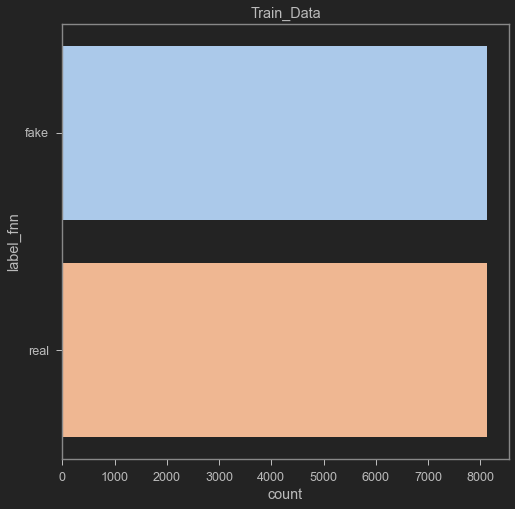

In [158]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "label_fnn", palette = "pastel", data = df).set_title('Train_Data')

Text(0.5, 1.0, 'Test_Data')

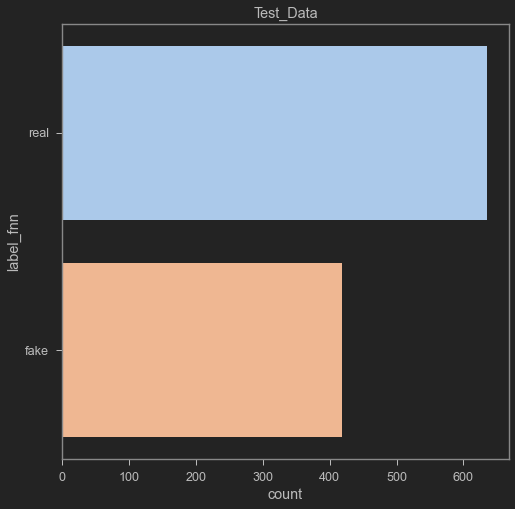

In [159]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 8))
sns.countplot(y = "label_fnn", palette = "pastel", data = df1).set_title('Test_Data')

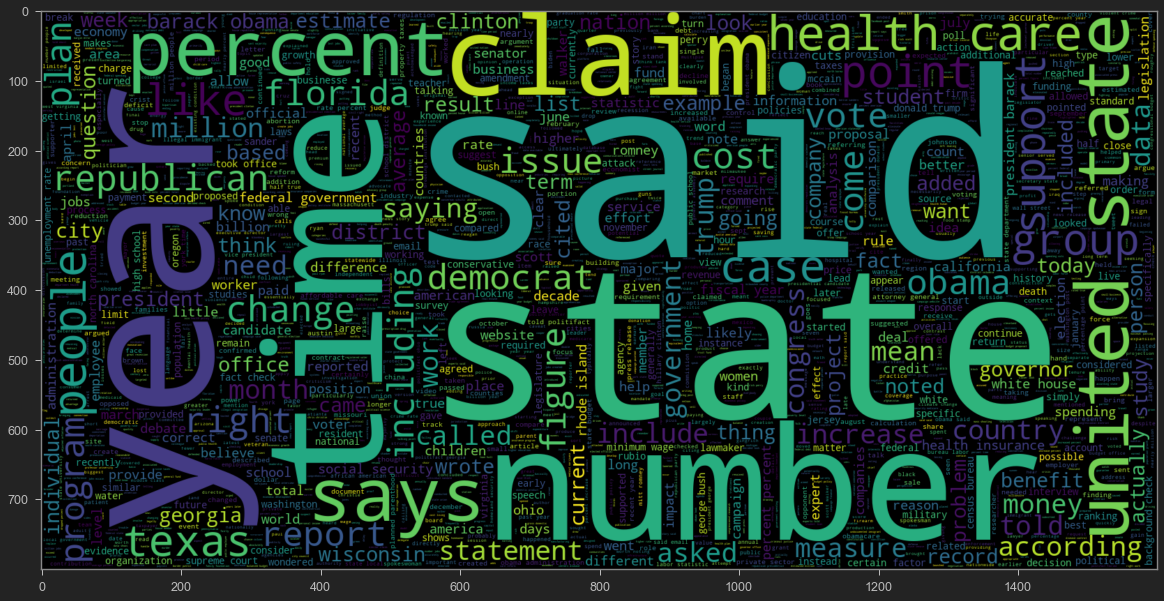

In [160]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.label_fnn == 'real'].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

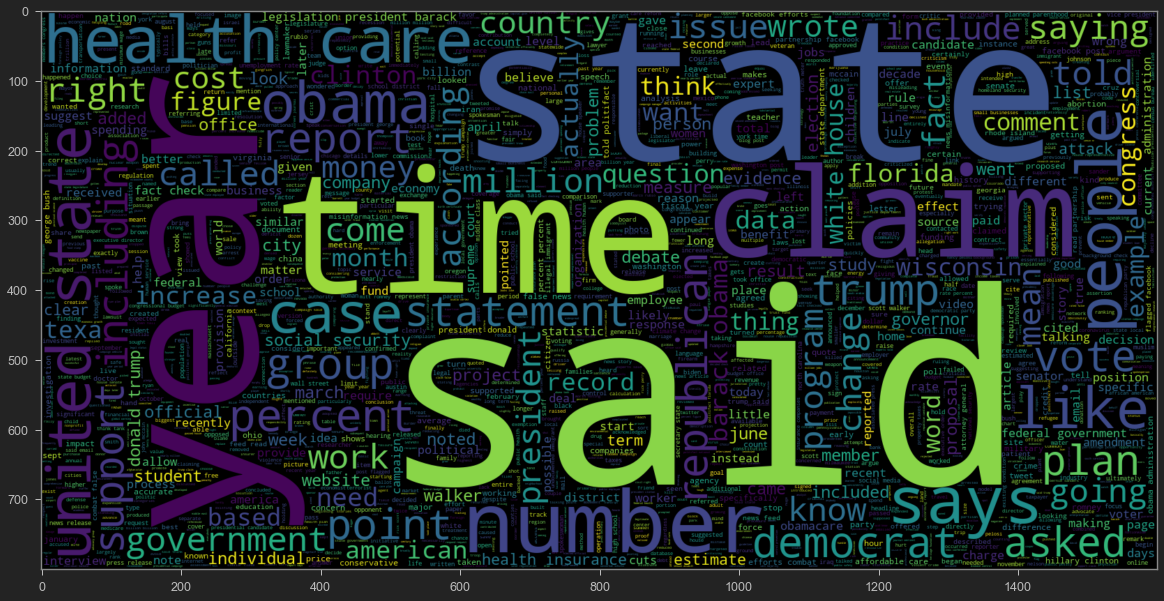

In [161]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.label_fnn == 'fake'].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [162]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 1672


In [163]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [164]:
# TASK #6: PREPARE THE DATA BY PERFORMING TOKENIZATION AND PADDING

In [165]:
x_train = df.clean_joined
y_train = df.label_fnn
x_test = df1.clean_joined
y_test = df1.label_fnn

In [166]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y_train = labelencoder_y.fit_transform(y_train)
y_test = labelencoder_y.fit_transform(y_test)

In [167]:
from nltk import word_tokenize

In [168]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [169]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 rubio swap proposal massive increase charlie crist launched amounts nuclear attack republican politics news sunday showdown marco rubio crist labeled rubio house speaker raiser forth record issues crist singled rubio failed plan eliminated property taxes floridians exchange increase state sales swap massive increase crist said march senate debate respect speaker tell truth people rubio contends swap huge plan supported bush hike look months speaker early rubio proposed fundamental change florida structure proposal scratch property taxes primary residences place state sales increased cents dollar voter approval house analysis originally said swap save taxpayers total billion year certainly contrary crist claim saved money spent money year likely depended individual circumstances petersburg times calculations rubio proposal homeowners renters homeowners family annual income home value current property tampa sales taxes paid proposed property tampa sales taxes p

In [170]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [171]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  313  8366   285  1454    73  1713   502  1777  1365   559   514    23
   659    30  1720  8961  1762   313   502  3274   313    21   686 12553
  2734   187   345   502  3814   313   626    46  2166   261    45  2281
   702    73     2   426]
The padded encoding for document 2  is :  [ 411  628  118 2277  225  170   84 3056  112  120  670 7023  115 6364
  118  850  225  417  238    1  231  565 2261  120  252  229 5720  361
  148  976 1509  323  112  120  658  383  511 1382  115  142]


In [172]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         8479872   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 8,776,065
Trainable params: 8,776,065
Non-trainable params: 0
_________________________________________________________________


In [173]:
total_words

66249

In [174]:
y_train = np.asarray(y_train)

In [178]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 10)
tf.autograph.experimental.do_not_convert

Epoch 1/2
229/229 [==============================] - 25s 110ms/step - loss: 0.1808 - acc: 0.9316 - val_loss: 0.9983 - val_acc: 0.5894
Epoch 2/2
229/229 [==============================] - 26s 113ms/step - loss: 0.0451 - acc: 0.9857 - val_loss: 1.9136 - val_acc: 0.5980


<function tensorflow.python.autograph.impl.api.do_not_convert(func=None)>

In [180]:
# make prediction
pred = model.predict(padded_test)
tf.autograph.experimental.do_not_convert

<function tensorflow.python.autograph.impl.api.do_not_convert(func=None)>

In [181]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [182]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.7239089184060721


<AxesSubplot:>

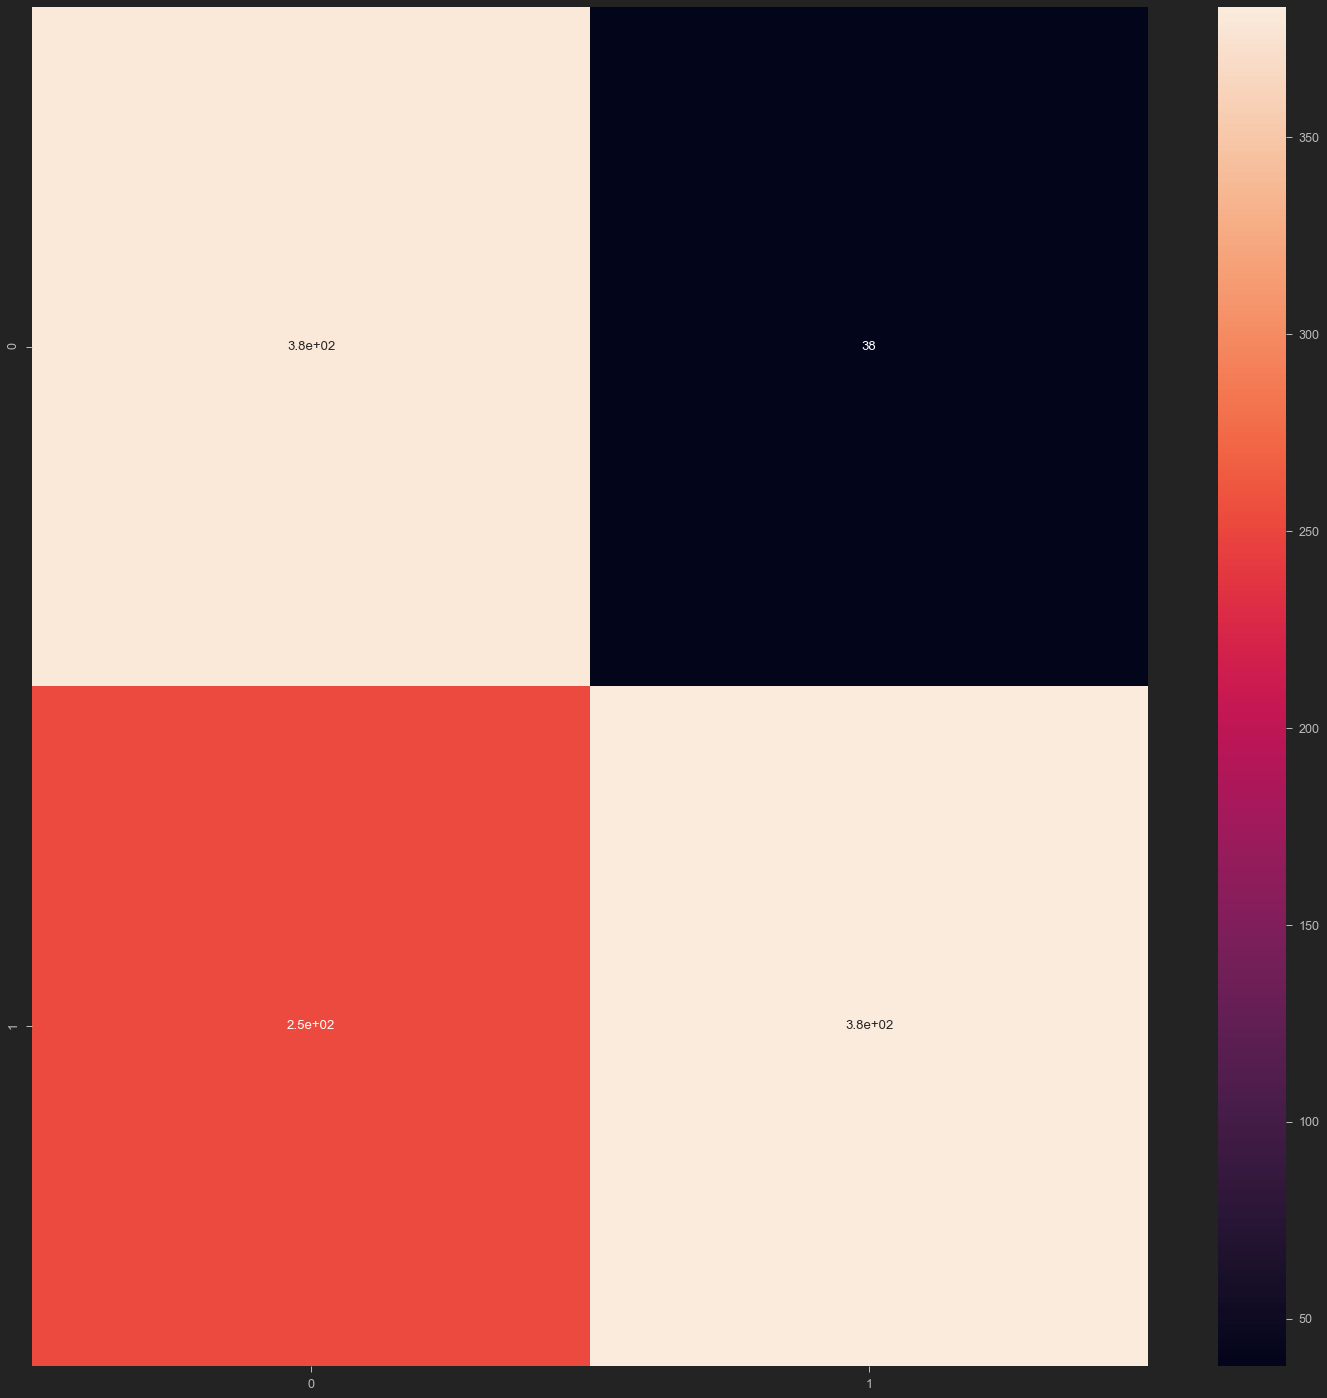

In [183]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)